------

------

# Write Code

# Algorithms.md

-------

-------

# Describe stuff

## Algorithm

**Description:** Groups datapoints into $k$ clusters. Initalizes centers as random selection of $k$ datapoints within the dataset, assigns data into cluster with nearest center. Recomputes cluster centers with current group membership. Reassigns data to clusters based on nearest center. Repeats last two steps until no changes are made between iterations.

**Inputs:** 
  1. $x_i \in \mathbb{R}^d$ for $i \in [n]=\{1,\ldots, n\}$, organized into a a matrix of datapoints with rows being observations and columns being dimensions, $A~\in~\mathbb{R}^{n \times d}$. 
  2. $k \in \mathbb{Z}_+$, the number of clusters to group data into.

**Outputs:** Vector of cluster assignments for each observation, $v \in [k]^n$.

**function** KMEANS ($A$,$k$)
  1. Initialize $v = $zeros$(n, 1)$ &nbsp;&nbsp;&nbsp;&nbsp; < create empty cluster vector assignment
  2. Initialize $v' = $ones$(n, 1)$ &nbsp;&nbsp;&nbsp;&nbsp; < create another empty cluster vector assignment
  3. Get $r = $int$($int$rand(k) \times n)$ &nbsp;&nbsp;&nbsp;&nbsp; < Pick random $k$ points to set as clusters centers
  4. Set $c = A(r, :)$ &nbsp;&nbsp;&nbsp;&nbsp; < Get initial cluster centers
  5. **while** $v'$ is not $v$} &nbsp;&nbsp;&nbsp;&nbsp; < while last two cluster assignments aren't the same
    1. $v = v'$ &nbsp;&nbsp;&nbsp;&nbsp; < save last cluster assignment
    1. **for**$i = 1,...,n$ &nbsp;&nbsp;&nbsp;&nbsp; < for each observation
      1. Set $d = $zeros$(k, 1)$ &nbsp;&nbsp;&nbsp;&nbsp; < set distances from point to centers as zero
      2. **for**{$j = 1,...,k$} &nbsp;&nbsp;&nbsp;&nbsp; < for each cluster
        1. $d(j) = $distance$(A(i, :), c(j, :))$ &nbsp;&nbsp;&nbsp;&nbsp; < compute distance
      3.**endfor**
      4. $v'(j) = $where$($min$(d))$ &nbsp;&nbsp;&nbsp;&nbsp; < assign current observation to nearest cluster
    2. **endfor**
    3. **for** $j = 1,...,k$
      1. $c(j, :) = $mean$(A($where$(v' == j), :))$ &nbsp;&nbsp;&nbsp;&nbsp; < update centers with mean of cluster
    4. **endfor**
  6. **endwhile**
**endfunction**


## Simulation

Data will be sampled from a Uniform Distribution (generated by numpy) with a scale and offset determined by the generating class.

#### Success
- 1-D vector of 20 observations, two clusters with
  - 10 of them class 0 with values between 0 and 1, and
  - 10 of them class 1 with values between 4 and 5

We expect k-means to do well in this situation because the means of the two classes are different.

#### Failure
- 1-D vector of 20 observations, two clusters with
  - 10 of them class 0 with values between -1 and 1, and
  - 10 of them class 1 with values between -5 and 5
  
We expect k-means to fail in this case because the means of the two classes are the same, though the distributions from which they're sampled has a different variance.


## Analysis

#### Qualitative visualizations
We will use a scatter plot in which the clusters are shown as the colour of the points belonging to them, with a legend identifying cluster ID. We will plot, next to this, the true cluster memberships.

#### Quantitative score
We will use the *truth* function (i.e. 0-1 loss), which returns 1 if values match and 0 if they do not. Because cluster value is arbitrary, we will first sort the clusters to be in ascending order based on their center.

#### Summary plot
We will use a histogram of the performance (i.e. portion of the points labeled correctly) to summarize the quantitative performance over a series of simulations.

#### P-value &  test statistic

- **Test Statistic** ???
- **Null Distribution** We will create a null distribution by running a permutation test (i.e. randomly assigning cluster labels to points and recording the distribution of performance), and the p-value will be reported as 1 minus the fraction of times the algorithm performs better than points in the null distribution.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Fix random seed
np.random.seed(123456789)

### 1. Generate simulated data for both settings

In [2]:
def simulate_s(n):
    """
    Simulates data with different mean but same variance
    
    inp:
        @n: number of samples
    outp:
        @A: data vector
        @y: true labels
    """
    A = np.random.random(n)
    A[int(n/2):] += 4

    y = np.repeat(0, n)
    y[int(n/2):] += 1
    return (A, y)

def simulate_f(n):
    """
    Simulates data with same mean but different variance
    
    inp:
        @n: number of samples
    outp:
        @A: data vector
        @y: true labels
    """
    A = np.append(np.random.random(int(np.floor(n/2)))*10-5, np.random.random(int(np.ceil(n/2)))*2-1)

    y = np.repeat(0, n)
    y[int(np.ceil(n/2)):] += 1
    return (A, y)

### 2. Plotting code for simulated data

In [3]:
def plotsimdata(A, y):
    """
    Plots simulated data vector coloured by label
    
    inp:
        @A: data vector
        @y: true labels
    """
    plt.figure(figsize=(4, 5))
    plt.scatter(np.zeros(sum(y==0)), A[y==0], color='blue')
    plt.scatter(np.zeros(sum(y==1)), A[y==1], color='red')
    plt.title('Truth (Simulation 1)')
    plt.ylabel('Value')
    plt.yticks([np.floor(np.min(A)), np.ceil(np.max(A))])
    plt.xticks([0])
    plt.ylim([np.floor(np.min(A)), np.ceil(np.max(A))])
    plt.legend(['Class 0', 'Class 1'], bbox_to_anchor=(1.5, 1))

    plt.show()

### 3. Algorithm code

In [4]:
def kmeans_1d(dat, k):
    """
    Clusters entries in A into k clusters
    
    inp:
        @dat: data matrix
        @k: number of classes
    outp:
        @c: estimated labels
    """
    classif = KMeans(n_clusters=k, random_state=0).fit(dat.reshape(-1,1))
    c = classif.labels_
    cent = classif.cluster_centers_
    a = sorted(range(len(cent)), key=lambda k: cent[k])

    # Super janky, toggles labels if permutated in 2-class case
    c = np.array([0 if a[0] == item else a[0] for item in c])
    return c

### 4. Qualitative evaluation (eg, figures) code per trial

In [5]:
def plotclusters(A, y, c):
    """
    Plots data coloured by both true and estimated label
    inp:
        @A: data vector
        @y: true labels
        @c: estimated labels
    """
    plt.figure(figsize=(4, 5))
    plt.scatter(np.zeros(sum(y==0)), A[y==0], color='blue')
    plt.scatter(np.zeros(sum(y==1)), A[y==1], color='red')
    plt.ylabel('Value')
    plt.yticks([np.floor(np.min(A)), np.ceil(np.max(A))])
    plt.xticks([0])
    plt.ylim([np.floor(np.min(A)), np.ceil(np.max(A))])
    plt.scatter(np.ones(sum(c==0)), A[c==0], color='blue')
    plt.scatter(np.ones(sum(c==1)), A[c==1], color='red')
    plt.legend(['Class 0', 'Class 1'], bbox_to_anchor=(2, 1))
    plt.title('Portion successfully labeled: %.3f' % truth(y,c))
    plt.yticks([np.floor(np.min(A)), np.ceil(np.max(A))])
    plt.xticks([0, 1], ['Truth', 'Estimated'])
    plt.xlim([-.5, 1.5])
    plt.ylim([np.floor(np.min(A)), np.ceil(np.max(A))])

    plt.show()

### 5. Quantitative evaluation code per trial

In [6]:
def truth(y, c):
    """
    Computes the percent of successful label assignments
    
    inp:
        @y: true labels
        @c: estimated labels
    outp:
        @p: percent corrent labels (ranging from [0, 1])
    """
    p = 1.0*(y == c)
    p = np.sum(p)/len(y)
    return p

### 6. Qualitative evaluation (eg, figures) over all experiments

In [7]:
def plotmeans(true, est):
    """
    Plots data coloured by both true and estimated label
    inp:
        @true: true cluster means from simulations as a list of lists 
        @estimated: estimated cluster means from simulations as a list of lists
    """
    plt.figure(figsize=(4, 5))
    xs = [0, 0.5]
    cols = ['blue', 'red']
    for idx, sim in enumerate(true):
        dat0 = [true[idx][0], est[idx][0]]
        dat1 = [true[idx][1], est[idx][1]]
        plt.plot(xs, dat0, 'bo--')
        plt.plot(xs, dat1, 'ro--')
    plt.title('Qualitative Evaluation')
    plt.ylabel('Value')
    plt.yticks([np.floor(np.min([true, est])), np.ceil(np.max([true, est]))])
    plt.xlim([xs[0]-0.2, xs[1]+0.2])
    plt.xticks(xs, ['Truth', 'Estimated'])
    plt.ylim([np.floor(np.min([true, est])), np.ceil(np.max([true, est]))])

    plt.show()

### 7. Quantitative evaluation code over all experiments

In [8]:
def plothist(score, n_score, pval, deg):
    """
    Plots the histogram of the null distribution and shows the estimation performance
    
    inp:
        @score: score of estimation
        @n_score: scores from null distribution
        @pval: calculated pvalue
        @deg: degree of confidence
    """
    plt.hist(n_score, bins=15, color='black')
    plt.hold(True)
    plt.vlines(score, 0, len(n_score)/4, color='red')
    plt.xlim([-0.1, 1.1])
    plt.title('P-value >= %.*f' % (abs(int(deg)), pval))
    plt.xlabel('performance')
    plt.ylabel('count')
    plt.legend(['estimation', 'null distribution'], bbox_to_anchor=(1.6, 1))
    plt.show()

def get_pval(y, c, d=1000):
    """
    Samples null distribution given a true set of labels and computes pval
    
    inp:
        @y: true labels
        @c: estimated labels
        @d: number of times to sample from null
    outp:
        @pval: p value
        @deg: degree of confidence in answer (in the form of 10^-${deg})
    """
    score = truth(y, c)
    n_score = []
    for i in range(d):
        t = np.random.permutation(y)
        n_score += [truth(y, t)]
    sums = 1.0*(score < n_score)
    pval = sum(sums)/len(sums)
    
    deg = -np.log10(d)
    plothist(score, n_score, pval, deg)
    return pval, deg

# A, y = simulate_f(800)
# c = my_kmeans_1d(A, 2)
# pval, deg = get_pval(y, c, 1000)

------

------
# Experiments

### Simulated Data

#### Simulation of success

I expect the simulated data to look like two highly concentrated classes that are clearly separated.

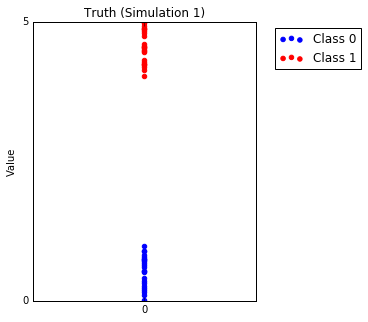

In [9]:
A, y = simulate_s(50)
plotsimdata(A, y)

My simulation data looks as I expected it to.

#### Simulation of failure

I expect my simulation data to contain two classes overlapping, one with a tight variance and the other with a large variance.

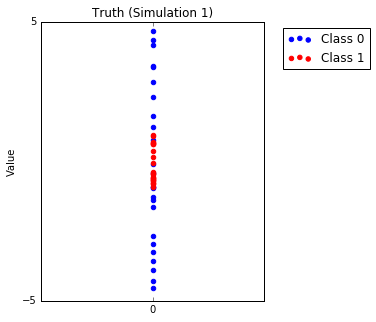

In [10]:
A, y = simulate_f(50)
plotsimdata(A, y)

My simulation data looks as I expected it to.

### Simulated Analysis

#### Simulation of success

I expect the algorithm to easily identify the two clusters as their means are considerably different and the two populations are non-overlapping in $\mathbb{R}^1$.

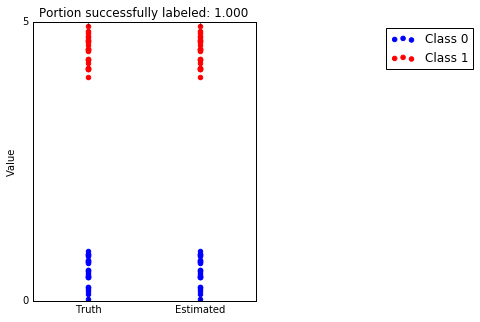

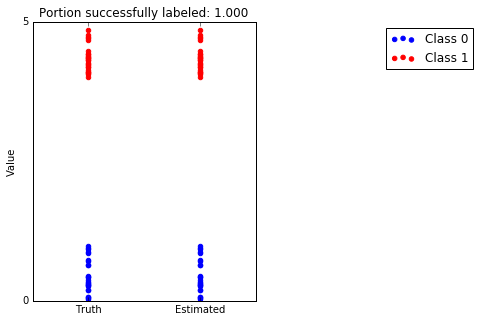

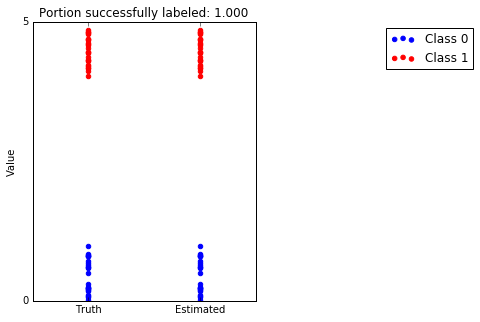

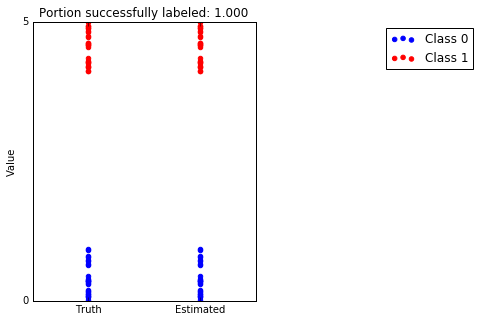

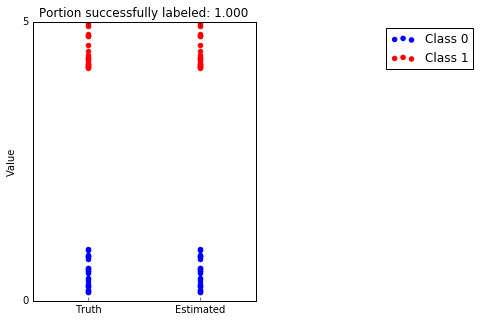

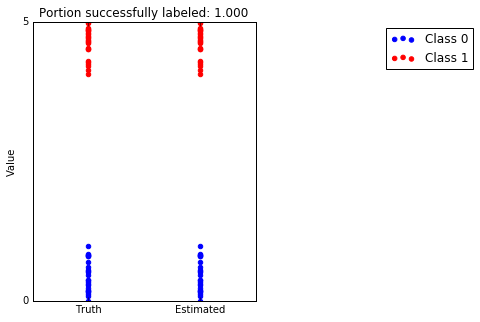

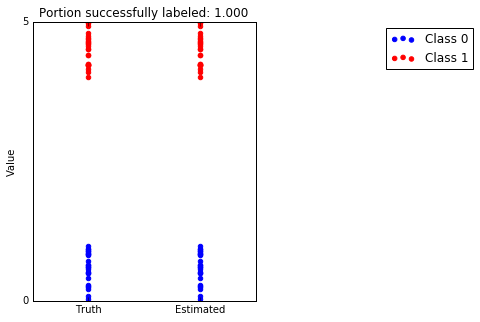

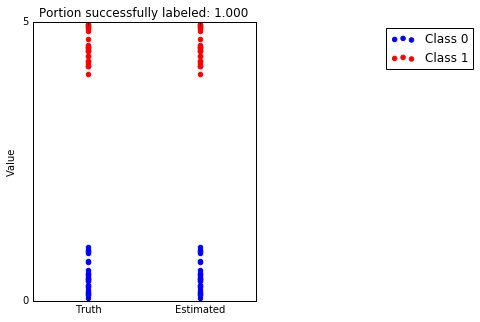

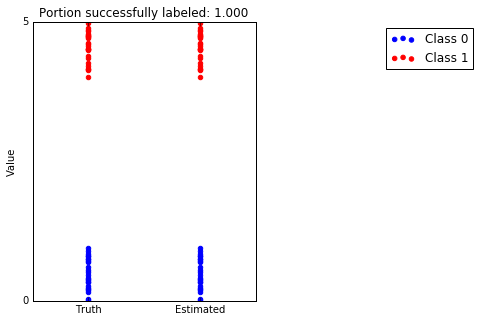

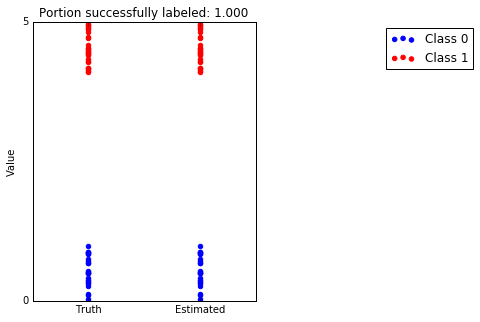

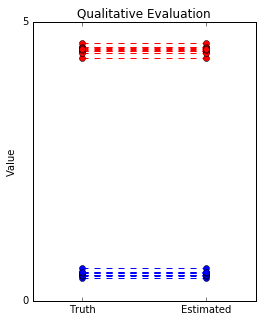

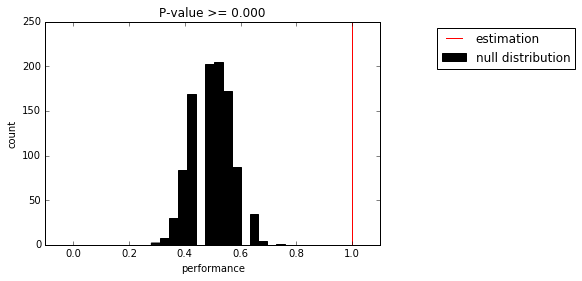

In [11]:
clusters = []
true_centers = []
est_centers = []
for idx in range(10):
    A, y = simulate_s(50)
    c = kmeans_1d(A, 2)
    plotclusters(A, y, c)
    true_centers += [[np.mean(A[np.where(y==0)]), np.mean(A[np.where(y==1)])]]
    est_centers += [[np.mean(A[np.where(c==0)]), np.mean(A[np.where(c==1)])]]
    clusters += [[c]]
plotmeans(true_centers, est_centers)
med_c = np.median(clusters[0], 0)
pval, conf = get_pval(y, med_c)

Happily, I observe that my algorithm perfomed as expected on this data.

#### Simulation of failure

I expect the algorithm to fail to identify the two clusters as their means are the same thus despite a different variane they overlap heavily in $\mathbb{R}^1$.

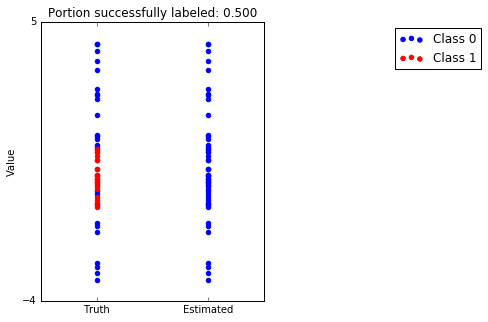

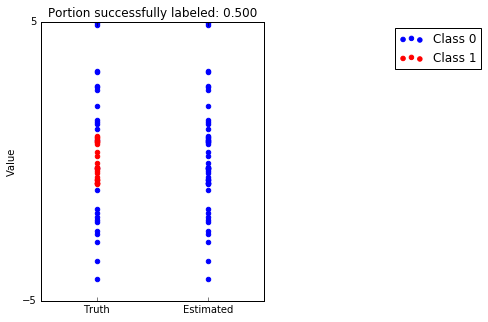

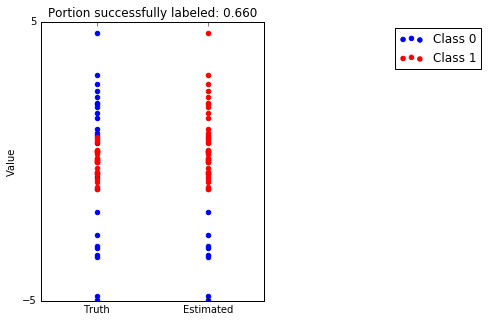

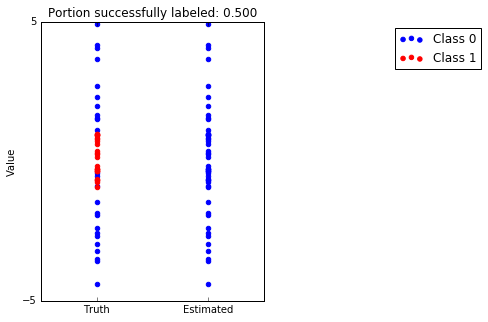

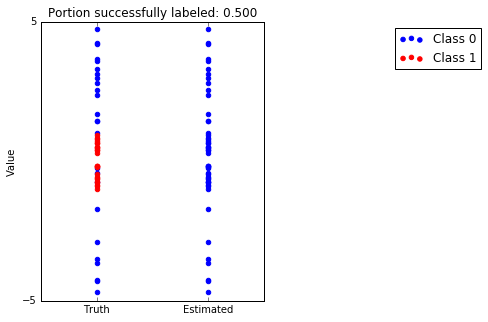

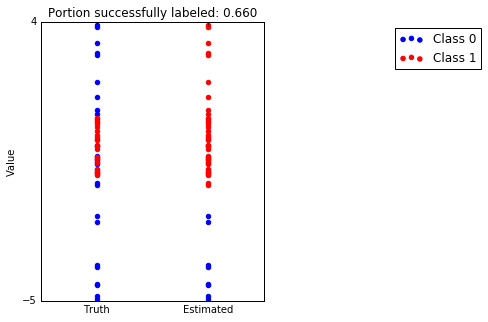

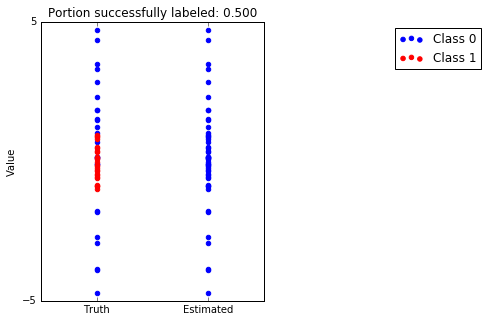

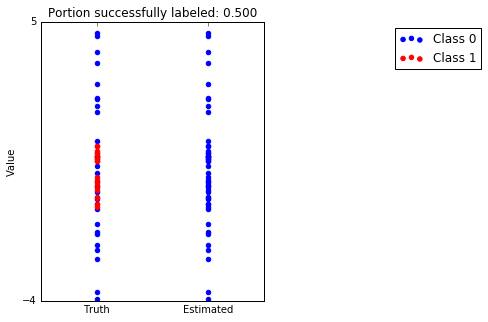

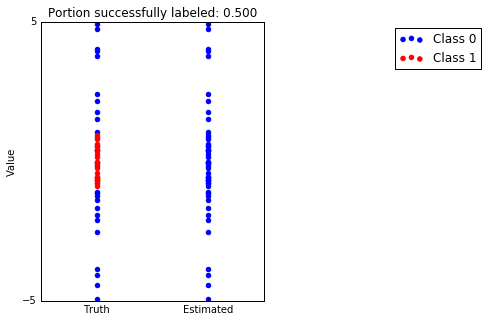

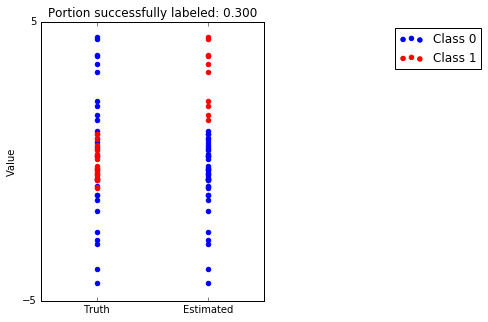

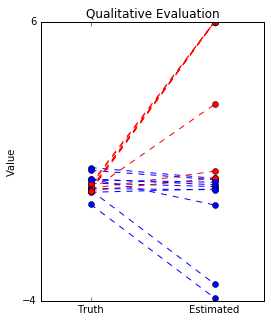

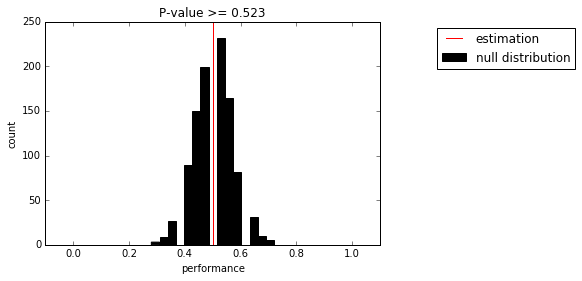

In [12]:
def replace_nans(est, val):
    """
    Replaces nan values with whatever value you want - necessary if a cluster is empty
    
    inp:
        @est: estimated clusters
        @val: value to replace
    """
    for idx, cent in enumerate(est):
        if np.isnan(cent[1]):
            est[idx][1] = val
        elif np.isnan(cent[1]):
            est[idx][1] = val
    return est

clusters = []
true_centers = []
est_centers = []
for idx in range(10):
    A, y = simulate_f(50)
    c = kmeans_1d(A, 2)
    plotclusters(A, y, c)
    true_centers += [[np.mean(A[np.where(y==0)]), np.mean(A[np.where(y==1)])]]
    est_centers += [[np.mean(A[np.where(c==0)]), np.mean(A[np.where(c==1)])]]
    clusters += [[c]]
replace_nans(est_centers, 6)
plotmeans(true_centers, est_centers)
mean_c = np.mean(clusters[0], 0)
pval, conf = get_pval(y, mean_c)

Not surprisingly, the k-means algorithm performed poorly in this scenario.

------

------
# Demonstrate Some Real Data Utility

### 1. Describe in as much detail as possible, including number of samples, the space each sample lives in, and any indiosyncracies (eg, missing data, NaNs, etc.), for both motivating dataset and previously tested datasets

The data being processed is human subject height and weight data. All of the entries for both heigh and weight live in $\mathbb{R}^{1,+}$. The weight is being thresholded at the 50th percentile and it is being used as a label which we are trying to recover from clustering.

Previously tested data (and simulated data above) are similar in that real-valued numbers are being mapped to binary labels.

### 2. Plot raw data

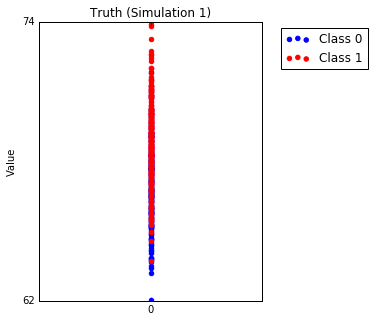

In [13]:
import csv
f = open('height_weight.csv')

A = []
y = []
reader = csv.reader(f)
for line in reader:
    A += [float(line[0])]
    y += [float(line[1])]

y = 1*(y > np.median(y))

A = np.array(A)
y = np.array(y)

plotsimdata(A, y)

### 3. Predict performance of the algorithm

Looking at the real data I notice there is a lot of overlap between the two clusters, leading me to suspect that the algorithm will not perform particularly well.

### 4. Run exact same code on real data as ran on simulations

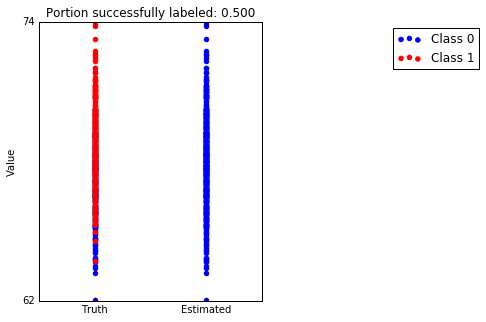

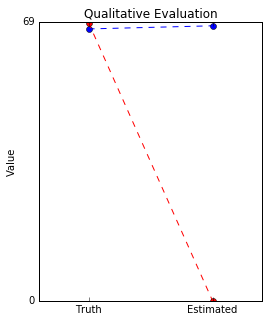

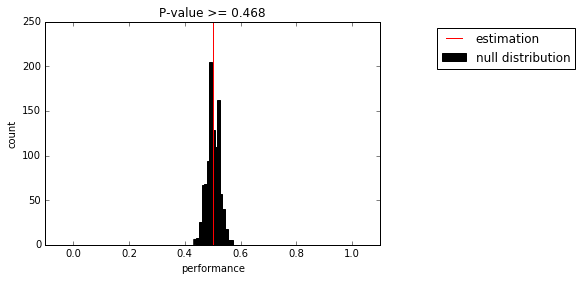

In [14]:
c = kmeans_1d(A, 2)
plotclusters(A, y, c)
true_centers = [[np.mean(A[np.where(y==0)]), np.mean(A[np.where(y==1)])]]
est_centers = [[np.mean(A[np.where(c==0)]), np.mean(A[np.where(c==1)])]]
clusters = [[c]]
replace_nans(est_centers, 0)
plotmeans(true_centers, est_centers)
med_c = np.median(clusters[0], 0)
pval, conf = get_pval(y, med_c)

### 5. Document performance accuracy relative to predictions

As predicted, the algorithm performed poorly on this data. In future, an algorithm that considers more than the mean of each cluster may be more successful.